In [65]:
from astroquery.sdss import SDSS
import math
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from specutils.fitting import fit_generic_continuum
from specutils import Spectrum
from labellines import labelLines
import matplotlib.axes as axes
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import scipy

plt.rcParams['agg.path.chunksize'] = 120

### Import a Spectra from astroquery.sdss

In [67]:
plate = 4531
mjd = 55563
fiber = 115

#Get spectra from astroquery
sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)

spec_hdu = sp[0]
spec_data = spec_hdu[1].data #data with the fits

z = spec_hdu[2].data["z"]

#print out the headers
header = spec_hdu[0].header

#set parameters
loglam = spec_data['loglam']
uncert = 1/np.sqrt(spec_data['ivar'])
flux = spec_data['flux']
wavelength = 10**loglam/(1+z)
print(spec_hdu[1].columns)

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)


C:\Users\nihad\AppData\Local\Temp\ipykernel_34296\4014317685.py:18: RuntimeWarning: divide by zero encountered in divide
  uncert = 1/np.sqrt(spec_data['ivar'])


### Plot the spectra 

C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:181: UserWarning: Tried to label line Line2D(_child6), but could not find a label for it.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=6564.610000000001, xmax=6564.610000000001, xval=6564.61). Clipping it into the allowed range.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=5008.240000000001, xmax=5008.240000000001, xval=5008.24). Clipping it into the allowed range.
  warnings.warn(
C:\Users\nihad\anaconda3\Lib\site-packages\labellines\core.py:267: UserWarning: The value at position 4 in `xvals` is outside the range of its associated line (xmin=4102.890000000001, xmax=4102.890000000001, xval=4102.89). Clipping it into the allowed range.
  warnings.warn(


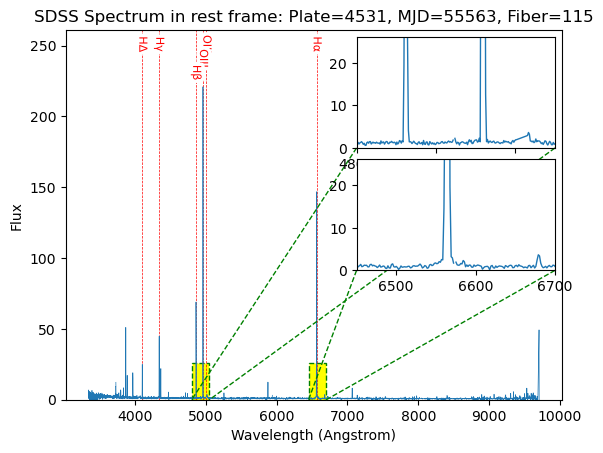

In [69]:
fig, ax = plt.subplots()

#common spectral lines in SDSS
xvals = [6564.61, 5008.240, 4960.295, 4862.68, 4102.89, 4341.68]
label = ['Hα', 'OIII', 'OIII', 'Hβ', 'HΔ', 'Hγ']

for i in range(len(xvals)):
     plt.axvline(xvals[i], color="red", linewidth=0.5, linestyle="--", label= label[i])

#plot the spectrum
ax.plot(wavelength, flux, linewidth=0.5)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
y_top = max(flux) + 40
plt.ylim(0,y_top)
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#vertical lines
offset = [y_top/2-10, y_top/2-10, y_top/2-20, y_top/2-30, y_top/2-10, y_top/2-10]
lines = plt.gca().get_lines()
labelLines(lines, align=True, yoffsets=offset, xvals = xvals, fontsize = 8)

#inset plot
inset1 = inset_axes(ax, width='40%', height='30%', loc='upper right',)
inset1.plot(wavelength, flux, linewidth=1)
inset1.set_xlim(4800, 5050)
inset1.set_ylim(0, y_top/10)
mark_inset(ax, inset1, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

#inset plot
inset2 = inset_axes(ax, width='40%', height='30%', loc='center right',)
inset2.plot(wavelength, flux, linewidth=1)
inset2.set_xlim(6450, 6700)
inset2.set_ylim(0, y_top/10)
mark_inset(ax, inset2, loc1=3, loc2=4, fc='yellow', ec='g', ls='--')

plt.show()

### Gaussian of the OIII lines (old)

In [23]:
#Gaussian with OII lines
def Gauss(x, amp, wid):
    return (amp * np.exp(-(x - 4960.295)**2 / (2 * wid**2))) + (3*amp * np.exp(-(x - 5008.240)**2 / (2 * wid**2)))

[232.75646061   0.96979979]


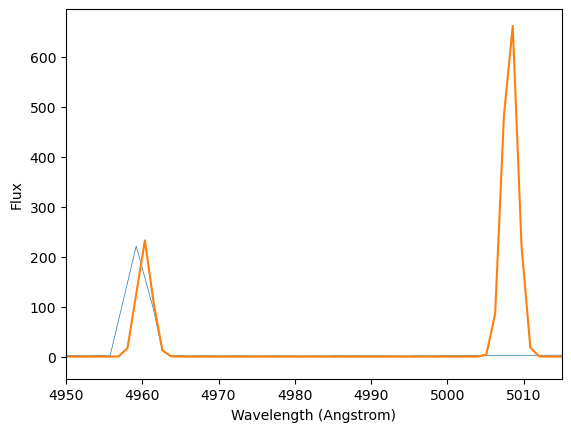

In [25]:
parameters, covariance = curve_fit(Gauss, wavelength, flux,sigma = uncert,  method = "lm", p0=[60, 2])
print(parameters)
fit_A, fit_B= parameters
fit_y = Gauss(wavelength, fit_A, fit_B)

#Plots the gaussian
plt.plot(wavelength, flux, linewidth=0.5, label='Data')
plt.plot(wavelength, fit_y, '-', label='Fit')

#ranges of x to show
plt.xlim(4950, 5015)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")

plt.show()

### Gauss of narrow + broad (with length units)

In [33]:
def h_alpha(x, amp, wid):
    return (amp * np.exp(-(x - 6564.61)**2 / (2 * wid**2)))
    
def n_ii_1(x, amp, wid):
    return (amp * np.exp(-(x - 6549.86)**2 / (2 * wid**2)))

def n_ii_2(x, amp, wid):
    return (3*amp * np.exp(-(x - 6585.27)**2 / (2 * wid**2)))

def broad(x, amp, wid):
    return (amp * np.exp(-(x - 6564.61)**2 / (2 * (wid)**2)))

def Gauss(x,b,amp1, amp2, amp3, wid1, wid2):
    return b+h_alpha(x, amp1, wid1) + n_ii_1(x, amp2, wid1) + n_ii_2(x, amp2, wid1) + broad(x, amp3, wid2)

[  1.06279716 301.06924292   0.42875761   3.32956731   1.27854227
   5.86400229]


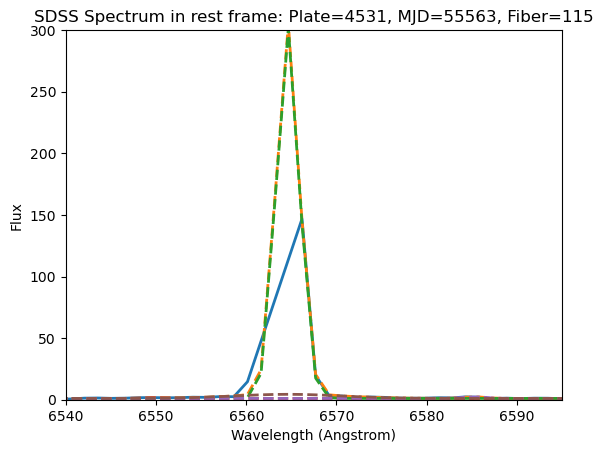

In [37]:
parameters, covariance = curve_fit(Gauss, wavelength, flux,sigma = uncert,  method = "lm", p0=[2, 200, 8, 2, 2, 5])
print(parameters)
A, B, C, D, E, F= parameters
fit_y = Gauss(wavelength, A, B, C, D, E, F)


#Plots the gaussian with the fits
plt.plot(wavelength, flux, linewidth=2, label='Data')
plt.plot(wavelength, fit_y, '--',linewidth=2, label='Fit')
plt.plot(wavelength, h_alpha(wavelength, B, E)+A, '--',linewidth=2, label='Fit')
plt.plot(wavelength, n_ii_1(wavelength, C, E)+A, '--',linewidth=2, label='Fit')
plt.plot(wavelength, n_ii_2(wavelength, C, E)+A, '--',linewidth=2, label='Fit')
plt.plot(wavelength, broad(wavelength, D, F)+A, '--',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(6540, 6595)
plt.ylim(0,300)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

#save the fit file
plt.savefig("Gaussian_fit_length.png")
plt.show()

### Fitting all gaussians in time units

In [61]:
c = 3*10**5 #km/s
inf = math.inf

def h_alpha(x, amp, sig, v):
    x_0 = 6564.61*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * wid**2)))

def n_ii_1(x, amp, sig, v):
    x_0 = 6549.86*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * wid**2)))

def n_ii_2(x, amp, sig, v):
    x_0 = 6585.27*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (3*amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * wid**2)))

def broad(x, amp, sig, v):
    x_0 = 6564.61*10**(-13) * (1+(v/c))
    wid= sig*x_0/c
    return (amp * np.exp(-(x*10**(-13) - x_0)**2 / (2 * (wid)**2)))

def Gauss(x,amp1, amp2, amp3, sig1, sig2, v_n, v_b, b):
    return h_alpha(x, amp1, sig1, v_n) + n_ii_1(x, amp2, sig1, v_n) + n_ii_2(x, amp2, sig1, v_n) + broad(x, amp3, sig2, v_b) +b

[ 4.46099619e+02  2.87151734e-01  1.29216141e+00  6.60913496e+01
  5.00000000e+02 -2.74668841e+01 -6.92491507e+00  1.06178514e+00]


Text(0.5, 1.0, 'SDSS Spectrum in rest frame: Plate=4531, MJD=55563, Fiber=115')

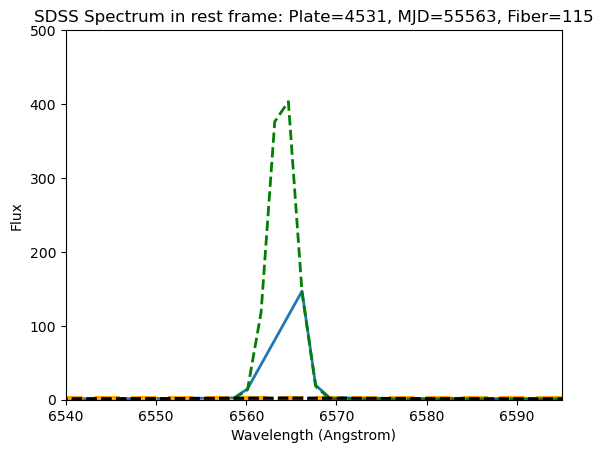

In [73]:
parameters, covariance = curve_fit(Gauss, wavelength, flux,sigma = uncert,  method = "trf", p0=[150,20,2, 50, 1000, 50, 50, 2], bounds=([0,0,0,50,500, -200, -2000, 0],[inf, inf,5,500, 5000, 200, 2000, 10]))
print(parameters)
A, B, C, D, E, F, G, H = parameters
fit = Gauss(wavelength/(1+z), A, B, C, D, E, F, G, H)

#plots the gaussian with fits
fig, ax = plt.subplots()
plt.plot(wavelength, flux, linewidth=2, label='Data')
plt.plot(wavelength, fit, '--', color = 'orange',linewidth=5, label='Fit')
plt.plot(wavelength, h_alpha(wavelength, A, D, F)+H, '--',color = 'green',linewidth=2, label='Fit')
plt.plot(wavelength, n_ii_1(wavelength, B, D, F)+H, '--',color = 'purple',linewidth=2, label='Fit')
plt.plot(wavelength, n_ii_2(wavelength, B, D, F)+H, '--',color = 'purple',linewidth=2, label='Fit')
plt.plot(wavelength, broad(wavelength, C, E, G)+H, '--',color = 'black',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(6540, 6595)
plt.ylim(0,500)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

Text(0.5, 1.0, 'SDSS Spectrum in rest frame: Plate=4531, MJD=55563, Fiber=115')

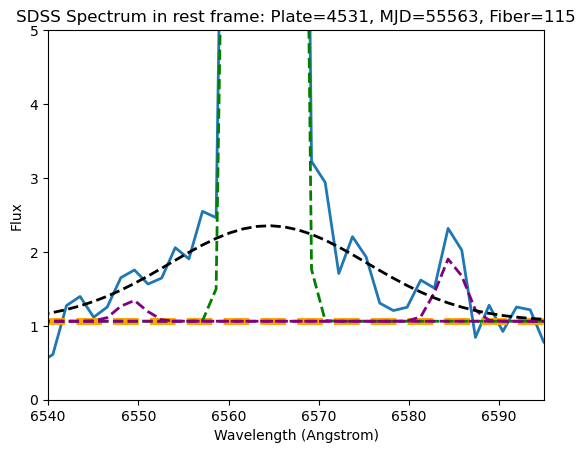

In [75]:
#plots the gaussian with fits
fig, ax = plt.subplots()
plt.plot(wavelength, flux, linewidth=2, label='Data')
plt.plot(wavelength, fit, '--', color = 'orange',linewidth=5, label='Fit')
plt.plot(wavelength, h_alpha(wavelength, A, D, F)+H, '--',color = 'green',linewidth=2, label='Fit')
plt.plot(wavelength, n_ii_1(wavelength, B, D, F)+H, '--',color = 'purple',linewidth=2, label='Fit')
plt.plot(wavelength, n_ii_2(wavelength, B, D, F)+H, '--',color = 'purple',linewidth=2, label='Fit')
plt.plot(wavelength, broad(wavelength, C, E, G)+H, '--',color = 'black',linewidth=2, label='Fit')

#ranges for x and y to show
plt.xlim(6540, 6595)
plt.ylim(0,5)

#labels
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
plt.title(f"SDSS Spectrum in rest frame: Plate={plate}, MJD={mjd}, Fiber={fiber}")

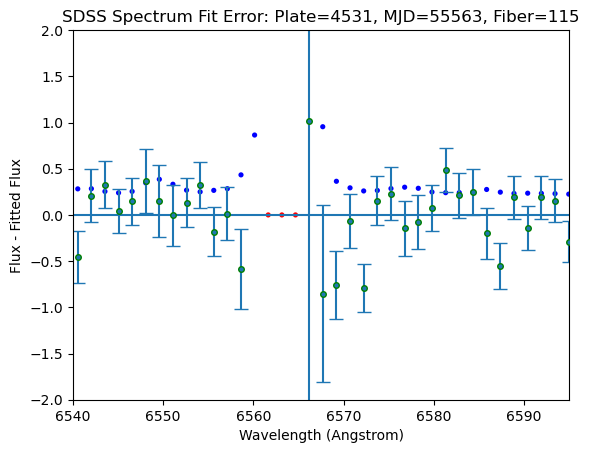

In [57]:
err = flux-fit_y
infty = []
color = []
uncert = [(1/np.sqrt(item)) if (item != 0) else 0 for item in spec_data['ivar']]
color = ['blue' if (item != 0) else 'red' for item in spec_data['ivar']]
plt.errorbar(wavelength, err, yerr = uncert, fmt='o',markersize=4, zorder=2.5, capsize=5, markeredgecolor="green", label='Data')
plt.scatter(wavelength, uncert, color = color, linewidth=2, s = 3, label='Data')
plt.axhline(y = 0)
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux - Fitted Flux")
plt.title(f"SDSS Spectrum Fit Error: Plate={plate}, MJD={mjd}, Fiber={fiber}")
plt.xlim(6540, 6595)
plt.ylim(-2, 2)
plt.savefig("Gaussian_fit_residuals.png")

plt.show()